In [18]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [28]:
# export
import os,sys,time,copy,math,numpy as np
from IPython.core.debugger import set_trace
import torch,torch.nn as nn,torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# export
class EncoderDecoder(nn.Module):
    '''
    A standard encoder-decoder architecture...
    '''
    def __init__(self,encr,decr,src_emb,tgt_emb,gen):
        super().__init__()
        self.encr = encr;self.decr = decr; self.src_emb = src_emb
        self.tgt_emb = tgt_emb; self.gen = gen
    
    def forward(self,src,tgt,src_mask,tgt_mask):
        return self.decode(self.encode(src,src_mask),src_mask,tgt,tgt_mask)
    
    def encode(self,src,src_mask):
        return self.encr(self.src_emb(src),src_mask)
    
    def decode(self,tgt,tgt_mask):
        return self.decr(self.tgt_emb(tgt),tgt_mask)
    

In [5]:
# export
class Generator(nn.Module):
    """
    Defines standard linear+ softmax step
    """
    def __init__(self,d_model,vocab):
        super().__init__()
        self.proj = nn.Linear(d_model,vocab)
        
    def forward(self,x):
        return F.log_softmax(self.proj(x),dim=-1)

In [7]:
# export
def clones(module,N):
    ''' Produces N identical modules '''
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Encoder

In [ ]:
# export
class Encoder(nn.Module):
    ''' Core encoder is a stack of N layers '''
    def __init__(self,layer,N):
        super().__init__()
        self.layers = clones(layer,N)
        self.norm  = LayerNorm(layer.size)
        
    def forward(self,x,mask):
        ''' Pass the input and mask through each layer in turn  '''
        for layer in self.layers:
            x = layer(x,mask)
        return self.norm(x)
        

### Layer Norm

In [8]:
# export
class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))        
        self.eps = eps
        
    def forward(self,x):
        mean = x.mean(-1,keepdim=True)
        std = x.std(-1,keepdim=True)
        return self.a_2*(x - mean)/(std + self.eps) + self.b_2

In [9]:
# export
class SubLayerConnection(nn.Module):
    """ A sum of original + layer(input) followed by layer Norm"""
    def __init__(self,size,p):
        super().__init__()
        self.norm = LayerNorm(size)
        self.p = nn.Dropout(p)
        
    def forward(self,x,sublayer):
        """ Apply residual connection to sublayer of same size"""
        return x + self.p(sublayer(self.norm(x)))

### basic encoder layer

In [11]:
# export
class BasicEncoderLayer(nn.Module):
    """ Basic encoder layer is made of self.attentiona and feed forward layer """
    def __init__(self,sz,slf_att,ff,p):
        super().__init__()
        self.slf_att = slf_att; self.sz = sz; self.ff = ff;
        self.sublayer = clones(SubLayerConnection(size,dropout),2)
        
    def forward(self,x):
        x = self.sublayer[0](x,lambda x: self.slf_att(x,x,x,mask))
        return self.sublayer[1](x,self.ff)

## Decoder

In [13]:
# export
class Decoder(nn.Module):
    ''' Basic N layer Decoder '''
    def __init__(self,layer,N):
        super().__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self,x,mem,src_msk,tgt_msk):
        for layer in self.layers:
            x = layer(x,mem,src_msk,tgt_msk)
        return self.norm(x)

In [14]:
# export
class BasicDecoderLayer(nn.Module):
    ''' Basic N layer Decoder '''
    def __init__(self,sz,slf_att,src_att,ff,p):
        super().__init__()
        self.slf_att = slf_att; self.src_att = src_att; self.ff = ff;
        self.sublayer  = clones(SubLayerConnection(sz,p), 3)
        
    def forward(self,x,mem,src_msk,tgt_msk):
        x = self.sublayer[0](x, lambda x: self.slf_att(x,x,x,tgt_msk))
        x = self.sublayer[1](x , lambda x: self.src_att(x,x,x,src_msk))
        return self.sublayer[2](x, lambda x:self.ff(x))

In [16]:
# export
def future_msk(sz):
    """ Mask out future positions. """
    att_shp = (1,sz,sz)
    future_msk = np.triu(np.ones(att_shp),k=1).astype('uint8')
    return torch.from_numpy(future_msk) ==0

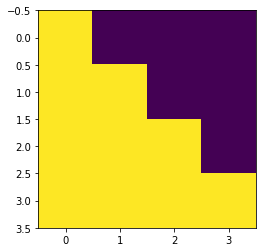

In [27]:
plt.imshow(future_msk(4)[0])

## Attention Layer

In [29]:
# export
def attention(q,k,v,msk=None,p=None):
    """ Compute 'Scaled dot product attention' """
    d_k = q.size(-1)
    scores = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
    if msk is not None:
        scores = scores.masked_fill(mask==0,-1e9)
        p_att = F.softmax(scores,dim = -1)
        if p is not None:
            p_att = p(p_att)
        return torch.matmul(p_att,v), p_att

In [90]:
# export
class MultiHeadAttention(nn.Module):
    def __init__(self,h, d_model, p=0.1):
        " Take in model size and number of heads."
        super().__init__()
        assert d_model % h ==0
        ## assumption d_v always equals d_k
        self.d_k = d_model // h; self.h = h; self.att = None; self.p = nn.Dropout(p=p)
        self.linears = clones(nn.Linear(d_model,d_model), 4)
    
    def forward(self,q,k,v,msk=None):
        'Implements figure 2'
        if msk is not None:
            # same mask for all heads? - Why
            msk = msk[:,None,...]
        nbtch = q.size(0)
        # 1. Do all the linear projections in batch  from d_model => h x d_k
        q,k,v = [l(x).view(nbtch,-1,self.h,self.d_k).transpose(1,2)
                for l,x in zip(self.linears,(q,k,v))]
        # 2. Apply attention to all the projected vectors in batch.
        x,self.att = attention(q,k,v,mask=mask,p=self.p)
        # 3.'Concat' using a view and apply a final linear.
        x = x.transpose(1,2).contigous().view(nbtch,-1,self.h*self.d_k)
        return self.linears[-1](x)

### feed forward

In [91]:
# export
class BasicFC(nn.Module):
    ''' Base FC to apply at the end of each encoder-decoder block '''
    def __init__(self,d_model,d_h,p=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model,d_h)
        self.w_2 = nn.Linear(d_h,d_model)
        self.p = nn.Dropout(p)
        
    def forward(self,x):
        return self.w_2(self.p(F.relu(self.w_1(x))))        
        

### Embeddings and softmax

In [92]:
# export
class Embeddings(nn.Module):
    def __init__(self,d_model,vocab):
        super().__init__()
        self.lidx = nn.Embedding(d_model,vocab)
        self.d_model = d_model
        
    def forward(self,x):
        return self.lut(x)*math.sqrt(self.d_model)

### Position Encoding

In [93]:
# export
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,p,max_len=5000):
        super().__init__()
        self.p = nn.Dropout(p)
        # compute the poisitional encodings in log space
        pe = torch.zeros(max_len,d_model)
        position = torch.arange(0,max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0.,d_model,2)* -(math.log(1000.0)/d_model))
#         breakpoint()
        pe[:,0::2] = torch.sin(position * div_term).float()
        pe[:,1::2] = torch.cos(position * div_term).float()
        pe = pe[None]
        self.register_buffer('pe',pe)
    def forward(self,x):
        x  = x + torch.tensor(self.pe[:,x.size(1)])
        return self.p(x)
        
        

In [86]:
pe = PositionalEncoding(20,0)
y = pe.forward(torch.zeros((1,100,20),requires_grad=True))

/home/shang/.conda/envs/pyfast/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


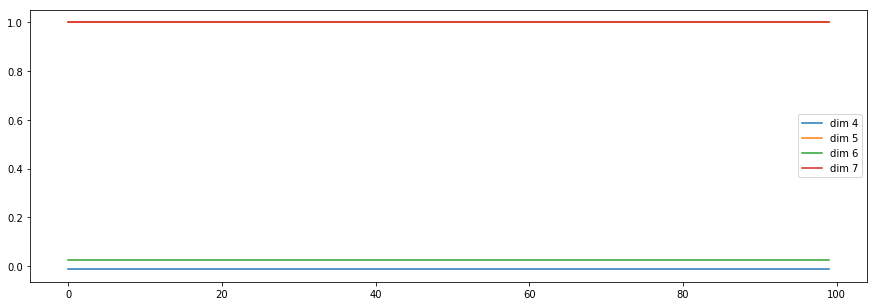

In [87]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(100),y[0,:,4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [94]:
! ../notebook2script.py ./attention_module.ipynb

Converted attention_module.ipynb to nb_attention.py


In [95]:
!cat ./exp/nb_attention.py


#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/attention_module.ipynb

import os,sys,time,copy,math,numpy as np
from IPython.core.debugger import set_trace
import torch,torch.nn as nn,torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

class EncoderDecoder(nn.Module):
    '''
    A standard encoder-decoder architecture...
    '''
    def __init__(self,encr,decr,src_emb,tgt_emb,gen):
        super().__init__()
        self.encr = encr;self.decr = decr; self.src_emb = src_emb
        self.tgt_emb = tgt_emb; self.gen = gen

    def forward(self,src,tgt,src_mask,tgt_mask):
        return self.decode(self.encode(src,src_mask),src_mask,tgt,tgt_mask)

    def encode(self,src,src_mask):
        return self.encr(self.src_emb(src),src_mask)

    def decode(self,tgt,tgt_mask):
        return self.decr(self.tgt_emb(tgt),tgt_mask)


class Generat